# Project: App-Review Miner
Team members: Shanshan Li, Yingyezhe Jin, Tianshu Chu, Xiao Huang

In [11]:
# Put all import here
import numpy as np
import lda
import lda.datasets

### NLP based preprocessing

    Inputs:  datasetName
             rmStopWords control to remove stop words
             rmRareWords control to remove rarely occured words
             
    Outputs: trainSet    is a list of training reviews
             testSet     is a list of testing reviews
             unlabelSet  is a list of unlabeld reviews
             vocabulary  is the corresponding n vocabulary in a dictionary form {word, index}

In [91]:
%run ./AR_util.py
%run ./AR_reviewInstance.py
datasetName = "swiftkey" # four apps : facebook, templerun2, swiftkey, tapfish

rmStopWords = True # Removing stop words lead to information loss and bad f-score
rmRareWords = True

# trainSet/testSet/unlabel: dictionary of {label, reviews} for review data
# vocabulary: dictionary len = V and the positional index of each term in the doc vector
# set skParse True to directly read of the data that has been filtered out
skParse = False
if(skParse == False):
    # the vocabulary is the words on the training set!
    trainSet, testSet, unlabelSet, vocabulary = AR_parse(datasetName, rmStopWords, rmRareWords)

Vocabulary size for swiftkey : 1709
Training set Size: 1000
Testing set Size: 2000
Unlabeling set Size: 3282


### Naive Bayes based filtering

    Inputs:  train/test/unlabelSet   are the preprocessed reviews 
             vocabulary              is the corresponding vocabulary of the reviews
    Outputs: informMat    is a k*m np sparse matrix, k is the number of informative reviews, m is the length of vocabulary
             informRev    is a list of informative reviews

In [92]:
%run ./AR_classifier.py
# 1. Use the EM-NB or SVM to filter out the informative reviews
# informMat: the informative reviews in X x V sparse matrix from, X: documents size, V: vocabulary size
# informRev: corresponding reviews wrapped as a list of review instances
useSVM = True # SVM is way better than emnb in terms of the testing. 
               # But it may not filter out the information effectively
if(skParse == False):
    if(useSVM == False):
        informRev, informMat = AR_emnb(trainSet, testSet, unlabelSet, vocabulary, datasetName)
    else:
        informRev, informMat = AR_svm(trainSet, testSet, unlabelSet, vocabulary, datasetName)

    # write the result back to the file (optional)
    AR_writeReviews(informRev, datasetName)
else:
    # directly read from the file
    informRev, informMat, vocabulary = AR_loadReviews(datasetName)

print("Number of informative reviews: " + str(len(informRev)))

Average F-Score for the test data: 0.79566013565
Number of informative reviews: 788


### LDA topic clustering

    Inputs:  informMat  is the k*m np sparse matrix, k is the number of informative reviews, m  is the length of vocabulary
             informRev  is the informative review list
             vocabulary is the corresponding vocabulary dictionary
             n_topics   is the number of topics
    Outputs: doc_topic  is a k*n_topics np matrix, which indicates the probability
             vocab      is the vocabulary in the list form

In [93]:
%run ./AR_lda.py
# 2. Use the LDA to do the grouping based on the topic
# doc_topi : a k*n_topics np matrix, which indicates the probability of each review belongs to one of the topic
# vocab: a list of vocabulary words
n_topics = 20
doc_topic, vocab, top_words_list = AR_lda(informRev, informMat, vocabulary, n_topics)

INFO:lda:n_documents: 788
INFO:lda:vocab_size: 1709
INFO:lda:n_words: 6357
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -74057
INFO:lda:<500> log likelihood: -44293
INFO:lda:<999> log likelihood: -43855


Topic 0: text type lag messag close back select
Topic 1: keyboard wish could custom type set better
Topic 2: space also punctuat insert period bar add
Topic 3: word sometim predict sentenc letter middl place
Topic 4: support chines languag pleas input japanes soon
Topic 5: keyboard time everi phone updat default set
Topic 6: use seem phone well bit like quit
Topic 7: work predict correct email browser auto address
Topic 8: would option dictionari star add custom give
Topic 9: keyboard swiftkey need samsung galaxi stock note
Topic 10: theme add would wish nice like new
Topic 11: app crash time make issu chrome caus
Topic 12: need swype thing featur wish emoji miss
Topic 13: get languag download pack error english cannot
Topic 14: keyboard button need great option still good
Topic 15: like would one key love keyboard app
Topic 16: key press option long pleas new swift
Topic 17: word type delet suggest swipe remov want
Topic 18: updat get one thing lack come sure
Topic 19: word use predic

In [5]:
"""
doc_topic = model.doc_topic_
ClustNum = []
# print doc_topic[1]
for i in range(k):
    ClustNum.append(doc_topic[i].argmax())
print ClustNum
"""

'\ndoc_topic = model.doc_topic_\nClustNum = []\n# print doc_topic[1]\nfor i in range(k):\n    ClustNum.append(doc_topic[i].argmax())\nprint ClustNum\n'

### Ranking all the groups based on importance

    Inputs:  doc_topic      is a k*n_topics np matrix, which indicates the probability
             wg             is a row vector (1 * 2), where each element denotes the weight of the corresponding feature
             informRev      is the informative review list
    Outputs: group_scores   is a row vector (1 * 20), where each element is the score of the corresponding group
             sorted_indices is a row vector (1 * 20), where the ith element is the index of the group whose score is the ith largest

In [15]:
%run ./AR_ranker.py
wg = [0.85, 0.15]
group_scores, sorted_group_indices = group_rank(doc_topic, wg, informRev)
print('group scores:\n')
print(group_scores)
print('ranked indices:\n')
print(sorted_group_indices)

group scores:

[47.916119300577023, 45.06239427090388, 39.476884766475592, 37.63966442380385, 37.507094513471323, 36.940128492553221, 35.969507190401877, 34.144751084091489, 33.703171129646641, 33.34040317886209, 32.907467916483434, 32.734860613296824, 31.971167921117488, 31.544919658634104, 31.176708000992718, 30.833084342384694, 29.725812052566848, 28.407738017516269, 28.020319919968482, 26.91842584391561]
ranked indices:

[14, 5, 3, 19, 17, 9, 1, 4, 15, 7, 13, 6, 10, 0, 8, 12, 16, 2, 11, 18]


### Cluster the reviews using volume and use TextRank to rank each instance

    Inputs:  doc_topic  is a np matrix k*n_topic, where k is # of reviews
             informRev  is a list of all informative reviews
    Outputs: rankedInstance is a dict = {topic, list of ranked reviews with the score}

In [34]:
%run ./AR_textrank.py
AR_tfIdf(informRev)
rankedInstance = AR_textrank(doc_topic, informRev)

In construct the graph of reviews ---- Nodes: 1021 Edges: 38072
In construct the graph of reviews ---- Nodes: 1012 Edges: 21804
In construct the graph of reviews ---- Nodes: 894 Edges: 37456
In construct the graph of reviews ---- Nodes: 503 Edges: 3184
In construct the graph of reviews ---- Nodes: 751 Edges: 4436
In construct the graph of reviews ---- Nodes: 834 Edges: 20164
In construct the graph of reviews ---- Nodes: 803 Edges: 11438
In construct the graph of reviews ---- Nodes: 592 Edges: 6674
In construct the graph of reviews ---- Nodes: 672 Edges: 1214
In construct the graph of reviews ---- Nodes: 617 Edges: 5092
In construct the graph of reviews ---- Nodes: 595 Edges: 1742
In construct the graph of reviews ---- Nodes: 625 Edges: 3630
In construct the graph of reviews ---- Nodes: 1043 Edges: 35468
In construct the graph of reviews ---- Nodes: 567 Edges: 7974
In construct the graph of reviews ---- Nodes: 805 Edges: 5196
In construct the graph of reviews ---- Nodes: 726 Edges: 2752

In [84]:
# print the top 10 reviews:
for i in range(len(rankedInstance)):
    print("Instance review for topic group: " + str(i))
    for j in range(5):
        r_ind = rankedInstance[i][j][0]
        score = rankedInstance[i][j][1]
        print(str(j+1) + "th review " + "Text: " +  informRev[r_ind].text + " Score: " + str(score) )

Instance review for topic group: 0
1th review Text: doesnt open on dell streak 5 Score: 0.000999200639146
2th review Text: dosent open on my dell streak Score: 0.000999200639146
3th review Text: android 2 2 2 dell streak 5 please check since it crashes to home screen without showing error Score: 0.000999200639146
4th review Text: when i open with my lg thrill i get the imangi studios icon like normal but then it closes down Score: 0.000999200639146
5th review Text: with a stock dell streak all i get is a force close Score: 0.000999200639146
Instance review for topic group: 1
1th review Text: after a couple runs i lose all of my coins except for a few hundred and then my coins from the run i ve just finished will add onto those couple hundred Score: 0.00103103412663
2th review Text: noticed coins disappear they dont stay when iver a certain amount so u can never get 5000 or 10000 coins i got the 1000000 coin mark for tge level n didnt even see or use them Score: 0.00103103412663
3th rev

### Ranking all the reviews in each group based on their importance score

    Inputs: doc_topic             is a k*n_topics np matrix, which indicates the probability
            weight                is a row vector (1 * 3), where each element denotes the weight of the corresponding feature
    Outputs: topic_top10RevScores is a row vector (10 * 20), where each element is the ranked score of the corresponding review in each group

In [7]:
%run ./AR_reviewRanking.py
AR_tfIdf(informRev)
weight = [0.25, 0.25, 0.25, 0.25]
topic_top10RevScores = instance_ranking(doc_topic, weight, informRev)

Length of 0th topic has reviews: 1374
Length of 1th topic has reviews: 1536
Length of 2th topic has reviews: 1273
Length of 3th topic has reviews: 737
Length of 4th topic has reviews: 1204
Length of 5th topic has reviews: 1204
Length of 6th topic has reviews: 1291
Length of 7th topic has reviews: 1062
Length of 8th topic has reviews: 1102
Length of 9th topic has reviews: 946
Length of 10th topic has reviews: 1121
Length of 11th topic has reviews: 1117
Length of 12th topic has reviews: 1481
Length of 13th topic has reviews: 861
Length of 14th topic has reviews: 1243
Length of 15th topic has reviews: 1180
Length of 16th topic has reviews: 1205
Length of 17th topic has reviews: 1339
Length of 18th topic has reviews: 1151
Length of 19th topic has reviews: 1268


In [85]:
# print the top 10 reviews:
for i in range(len(topic_top10RevScores)):
    print("Instance review for topic group: " + str(i))
    for j in range(5):
        r_ind = topic_top10RevScores[i][j][0]
        score = topic_top10RevScores[i][j][1]
        print(str(j+1) + "th review " + "Text: " +  informRev[r_ind].text + " Score: " + str(score) )

Instance review for topic group: 0
1th review Text: opens and says imangi studios then closes and sends me to my home page Score: 0.9525
2th review Text: when i open game it shows imangi studio symbol in green but then closes out Score: 0.9525
3th review Text: i open it and the logo shows up and then it closes and goes to home screen Score: 0.947222222222
4th review Text: it stays on the imangi studios picture for a few seconds then force closes Score: 0.947222222222
5th review Text: sometimes when i try to play it just stay on the imangi screen and force closing idk why and it seems to lag a bit Score: 0.947222222222
Instance review for topic group: 1
1th review Text: paid 4 99 for the double coin thing Score: 0.905
2th review Text: i bought the double coins and it doesnt work wtf Score: 0.905
3th review Text: i did not receive the coins Score: 0.905
4th review Text: paid 4 99 for the double coin thing Score: 0.905
5th review Text: my coins are disappearing Score: 0.88125
Instance rev

### Visualization

    Inputs:  group_scores is a list of scores of each group
    Outputs: a radar chart

/home/jimmy/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


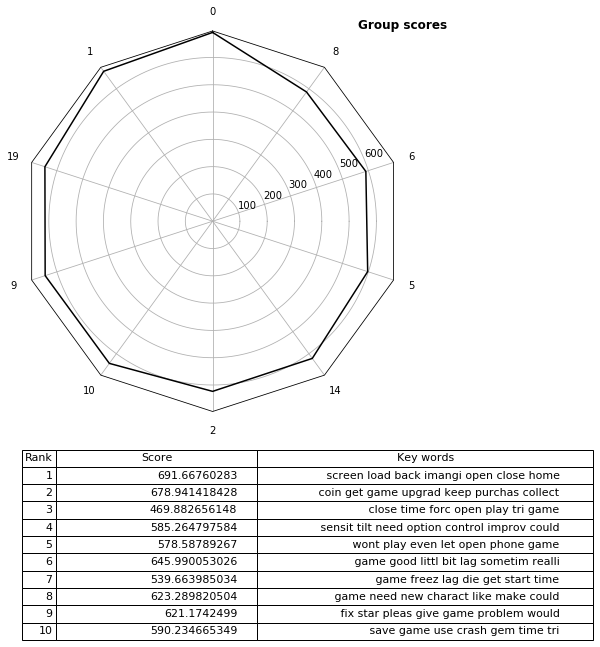

In [87]:
%run ./AR_visualization.py

group_count = 10
plot_group_ranking(group_scores, sorted_group_indices, top_words_list, group_count)